In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# General CBCP Equilibrium Solver

## (Special Case) Quartic Polynomial Latency Functions

In [2]:
x_temp = np.array([0, 1, 2, 3, 4])
x_temp[-2:]

array([3, 4])

In [3]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
# num_cols = arr.shape[1]
num_cols = 3
# arr[:, -num_cols:] - arr[:, -num_cols-1:-1]

np.linalg.norm(arr, axis=0)


array([12.56980509, 14.03566885, 15.55634919, 17.11724277, 18.70828693])

In [4]:
grad = np.array([0, 1, 2, 3, 4])

grad[2:]

array([2, 3, 4])

In [50]:
# Latency Function: a_4 x^4 + a_3 x^3 + a_2 x^2 + a_1 x + a_0

# Below: For quartic latency functions:
def solve_CBCP_direct(tau, B, v_I_list, v_E_list, \
                         a_ex = np.array([0.0, 0.0, 0.0, 0.0, 1.0]), \
                         a_gp = np.array([0.0, 0.0, 0.0, 0.0, 1.0])):

    num_in = len(v_I_list)
    num_el = len(v_E_list)
    
    # y_el: \hat y_1, \tilde y_1, y_2, ..., \hat y_1, \tilde y_1, y_2
    y_el = cp.Variable(3)
    # y_in: y_1, y_2, ..., y_1, y_2
    y_in = cp.Variable(2)
    
    c_el_ex = np.tile(np.array([1, 1, 0]), num_el)
    c_in_ex = np.tile(np.array([1, 0]), num_in)
    c_el_gp = np.tile(np.array([0, 0, 1]), num_el)
    c_in_gp = np.tile(np.array([0, 1]), num_in)
    
    func = 1/5 * a_ex[4] * cp.power(c_el_ex @ y_el + c_in_ex @ y_in, 5)
    func += 1/4 * a_ex[3] * cp.power(c_el_ex @ y_el + c_in_ex @ y_in, 4)
    func += 1/3 * a_ex[2] * cp.power(c_el_ex @ y_el + c_in_ex @ y_in, 3)
    func += 1/2 * a_ex[1] * cp.power(c_el_ex @ y_el + c_in_ex @ y_in, 2)
    func += a_ex[0] * (c_el_ex @ y_el + c_in_ex @ y_in)
    func += 1/5 * a_gp[4] * cp.power(c_el_gp @ y_el + c_in_gp @ y_in, 5)
    func += 1/4 * a_gp[3] * cp.power(c_el_gp @ y_el + c_in_gp @ y_in, 4)
    func += 1/3 * a_gp[2] * cp.power(c_el_gp @ y_el + c_in_gp @ y_in, 3)
    func += 1/2 * a_gp[1] * cp.power(c_el_gp @ y_el + c_in_gp @ y_in, 2)
    func += a_gp[0] * (c_el_gp @ y_el + c_in_gp @ y_in)
    
    for v_I_index, v_I in enumerate(v_I_list):
        func += y_in[v_I_index * 3] * tau / v_I 
    for v_E_index, v_E in enumerate(v_E_list):
        func += y_el[v_E_index * 2] * tau / v_E

    objective = cp.Minimize(func)
        
    C_el = np.kron(np.eye(num_in), np.array([1, 1, 1]))
    C_in = np.kron(np.eye(num_el), np.array([1, 1]))
    c_el_ex_budget = np.tile(np.array([0, 1, 0]), num_el)
    
    constraints = []
    constraints += [y_el >= 0, y_in >= 0]
    constraints += [C_el @ y_el == 1, C_in @ y_in == 1]
    constraints += [(c_el_ex_budget @ y_el) * tau <= B]
    
    prob = cp.Problem(objective, constraints)
    
    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
#     # The optimal value for x is stored in `x.value`.
#     print("In solve_CBCP_direct, y_el.value:", y_el.value)
#     print("In solve_CBCP_direct, y_in.value:", y_in.value)

    return y_el.value, y_in.value

In [51]:
def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I_list, v_E_list, y_el, y_in, \
                a_ex = np.array([0.0, 0.0, 0.0, 0.0, 1.0]), \
                a_gp = np.array([0.0, 0.0, 0.0, 0.0, 1.0])):
    
    num_in = len(v_I_list)
    num_el = len(v_E_list)
    
    # y = (\hat y_1 E, \tilde y_1 E, y_2 E, y_1 I, y_2 I)
    # y_el = (\hat y_1 E, \tilde y_1 E, y_2 E)
    # y_in = (y_1 I, y_2 I)
    
    c_el_ex = np.tile(np.array([1, 1, 0]), num_el)
    c_in_ex = np.tile(np.array([1, 0]), num_in)
    c_el_gp = np.tile(np.array([0, 0, 1]), num_el)
    c_in_gp = np.tile(np.array([0, 1]), num_in)
    
#     C_el = np.kron(np.eye(num_in), np.array([1, 1, 1]))
#     C_in = np.kron(np.eye(num_el), np.array([1, 1]))
#     c_el_ex_budget = np.tile(np.array([0, 1, 0]), num_el)
    
    ell_ex = a_ex[4] * (c_el_ex @ y_el + c_in_ex @ y_in)**4 \
            + a_ex[3] * (c_el_ex @ y_el + c_in_ex @ y_in)**3 \
            + a_ex[2] * (c_el_ex @ y_el + c_in_ex @ y_in)**2 \
            + a_ex[1] * (c_el_ex @ y_el + c_in_ex @ y_in) \
            + a_ex[0]
    
    ell_gp = a_gp[4] * (c_el_gp @ y_el + c_in_gp @ y_in)**4 \
            + a_gp[3] * (c_el_gp @ y_el + c_in_gp @ y_in)**3 \
            + a_gp[2] * (c_el_gp @ y_el + c_in_gp @ y_in)**2 \
            + a_gp[1] * (c_el_gp @ y_el + c_in_gp @ y_in) \
            + a_gp[0]
    
    c_el_ex_toll = np.tile(np.array([1, 0, 0]), num_el)
    c_in_ex_toll = np.tile(np.array([1, 0]), num_in)
    
    obj_E = tau * c_el_ex_toll @ y_el + v_E * (ell_ex * (c_el_ex @ y_el) + ell_gp * (c_el_gp @ y_el) )
    obj_R = tau * (c_el_ex_toll @ y_el + c_in_ex_toll @ y_in)
    obj_I = tau * c_in_ex_toll @ y_in + v_I * (ell_ex * (c_in_ex @ y_in) + ell_gp * (c_in_gp @ y_in) )
    
#     print("ell_ex:", ell_ex)
#     print("ell_gp:", ell_gp)
#     print("obj_E:", obj_E)
#     print("obj_R:", obj_R)

#     print("tau:", tau)
#     print("c_in_ex_toll @ y_in:", c_in_ex_toll @ y_in)
#     print("v_I:", v_I)
#     print("ell_ex:", ell_ex)
#     print("c_in_ex @ y_in:", c_in_ex @ y_in)
#     print("ell_gp:", ell_gp)
#     print("c_in_gp @ y_in:", c_in_gp @ y_in)
    
#     print("obj_I:", obj_I)

    return lambda_E * obj_E - lambda_R * obj_R + lambda_I * obj_I

    

In [10]:
def proj_tau_B_11(tau, B):
    if B <= tau and 0 <= tau <= 1 and 0 <= B <= 1:
        return tau, B
    # Case 1:
    elif tau > 1 and 0 < B <= 1:
        return 1.0, B
    # Case 2:
    elif tau > 1 and B <= 0:
        return 1.0, 0.0
    # Case 3:
    elif 0 < tau <= 1 and B < 0:
        return tau, 0.0
    # Case 4:
    elif tau <= 0 and B + tau < 0:
        return 0.0, 0.0
    # Case 5:
    elif 0 <= B + tau < 2 and B > tau:
        return (B + tau)/2, (B + tau)/2
    # Case 6:
    elif B + tau >= 2 and B > 1:
        return 1.0, 1.0
    else:
        assert 1 == 0, "This case should not happen!"

## Chinmay's Algorithm:

In [52]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.05, 0.95, 0.95, 0.05])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0

tau_max, B_max = 1.0, 1.0
d = 2
num_iters = 1000
tau = np.zeros(num_iters)
tau_perturbed = np.zeros(num_iters)
B = np.zeros(num_iters)
B_perturbed = np.zeros(num_iters)
tau_B_iters = np.zeros((2, num_iters))
delta = np.zeros(num_iters)
eta = np.zeros(num_iters)
eta_bar = 0.5
delta_bar = 0.5

welfare_list = []

tau[0] = 0.8
B[0] = 0.2

for i in range(num_iters-1):
    
    print()
    print("Iter:", i)
    
    eta[i] = eta_bar * (i+1)**(-1/2) * d**(-1)
    delta[i] = delta_bar * (i+1)**(-1/4) * d**(-1/2)
    w_i_unnormalized = np.random.randn(2)
    w_i = w_i_unnormalized / np.linalg.norm(w_i_unnormalized)
    print("w_i:", w_i)
    tau_perturbed[i] = tau[i] + delta[i] * w_i[0]
    B_perturbed[i] = B[i] + delta[i] * w_i[1]
    
    if tau_perturbed[i] < B_perturbed[i] or tau_perturbed[i] < 0 or B_perturbed[i] < 0:
        tau_perturbed[i], B_perturbed[i] = proj_tau_B_11(tau_perturbed[i], B_perturbed[i])
    
    # TODO
#     if B_perturbed[i] <= tau_perturbed[i] and B_perturbed[i] >= 0 and tau_perturbed[i] >= 0:        
    
#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (unperturbed):")
#     print()
    print("tau[i]:", tau[i])
    print("B[i]:", B[i])
    print("tau_perturbed[i]:", tau_perturbed[i])
    print("B_perturbed[i]:", B_perturbed[i])


    y_el, y_in = solve_CBCP_direct(tau = tau[i], B = B[i],\
                                   v_I_list = [v_I], v_E_list = [v_E], a_ex = a, a_gp = a)

#     print()
#     print("New solve_CBCP_iter_11 call to solve_CBCP (perturbed):")
#     print()
    y_el_perturbed, y_in_perturbed = solve_CBCP_direct(tau = tau_perturbed[i], B = B_perturbed[i], \
                                                       v_I_list = [v_I], v_E_list = [v_E], a_ex = a, a_gp = a)
    
#     print("y_el:", y_el)
#     print("y_in:", y_in)
#     print("y_el_perturbed:", y_el_perturbed)
#     print("y_in_perturbed:", y_in_perturbed)
    
    welfare = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau[i], v_I_list = [v_I], v_E_list = [v_E], \
                          y_el = y_el, y_in = y_in, a_ex = a, a_gp = a)
    welfare_perturbed = welfare_obj(lambda_E, lambda_R, lambda_I, tau = tau_perturbed[i], v_I_list = [v_I], v_E_list = [v_E], \
                                    y_el = y_el_perturbed, y_in = y_in_perturbed, a_ex = a, a_gp = a)
    
    welfare_list.append(welfare)
    
#     def welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I, v_E, y_el, y_in, \
#                 a_ex = np.array([0.0, 0.0, 0.0, 0.0, 1.0]), \
#                 a_gp = np.array([0.0, 0.0, 0.0, 0.0, 1.0]))
    
    print("welfare:", welfare)
    print("welfare_perturbed:", welfare_perturbed)
#     print("tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare):\n", tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare))
    
    tau[i+1] = tau[i] - eta[i] * (d/delta[i]) * w_i[0] * (welfare_perturbed - welfare)
    B[i+1] = B[i] - eta[i] * (d/delta[i]) * w_i[1] * (welfare_perturbed - welfare)

    if not (B[i+1] <= tau[i+1] and 0 <= tau[i+1] <= 1 and 0 <= B[i+1] <= 1):
        tau[i+1], B[i+1] = proj_tau_B_11(tau[i+1], B[i+1])
        
    if i >= diffs_num_cols + 2:
        tau_diffs = tau[i-diffs_num_cols : i-1] - tau[i-diffs_num_cols+1 : i]
        B_diffs = B[i-diffs_num_cols : i-1] - B[i-diffs_num_cols+1 : i]
        
#         print("tau[0:10]:", tau[0:10])
#         print("B[0:10]:", B[0:10])
        print("tau_diffs:", tau_diffs)
        print("B_diffs:", B_diffs)
        
        if max(np.max(np.absolute(tau_diffs)), np.max(np.absolute(B_diffs))) < error_bound:
            break

time_2 = time.time()

min_welfare = min(welfare_list)
argmin_welfare_list = welfare_list.index(min(welfare_list))
argmin_tau = tau[argmin_welfare_list]
argmin_B = B[argmin_welfare_list]

print()
print("Time:", time_2 - time_1)




Iter: 0
w_i: [ 0.96872516 -0.24813619]
tau[i]: 0.8
B[i]: 0.2
tau_perturbed[i]: 1.1424960636582067
B_perturbed[i]: 0.11227060709982227
welfare: 1.6935225534581637
welfare_perturbed: 1.7654023013632183

Iter: 1
w_i: [-0.23126305 -0.97289126]
tau[i]: 0.7015258771430984
B[i]: 0.22522386658211305
tau_perturbed[i]: 0.6327709622783301
B_perturbed[i]: 0.0
welfare: 1.683646513937953
welfare_perturbed: 1.5825656799728567

Iter: 2
w_i: [0.92739454 0.3740847 ]
tau[i]: 0.6737266606081784
B[i]: 0.10827645412080572
tau_perturbed[i]: 0.9228642334758934
B_perturbed[i]: 0.2087714959601285
welfare: 1.6321322449104259
welfare_perturbed: 1.7288085712123877

Iter: 3
w_i: [-0.90667213 -0.42183605]
tau[i]: 0.5773838394536264
B[i]: 0.06941448829445501
tau_perturbed[i]: 0.3507158074912214
B_perturbed[i]: 0.0
welfare: 1.6032834169618986
welfare_perturbed: 1.5635882434299664

Iter: 4
w_i: [ 0.97305937 -0.23055467]
tau[i]: 0.5413933320020695
B[i]: 0.05266963311115648
tau_perturbed[i]: 0.7714590164254552
B_perturb

welfare: 1.5661211187079138
welfare_perturbed: 1.5658777508818966
tau_diffs: [ 8.25133002e-05  2.13352865e-07 -1.79158680e-02  1.05566999e-02]
B_diffs: [ 0.00000000e+00 -3.28932584e-05  3.28932584e-05  0.00000000e+00]

Iter: 28
w_i: [0.77680198 0.62974494]
tau[i]: 0.4640479572856659
B[i]: 0.0
tau_perturbed[i]: 0.5823972942646936
B_perturbed[i]: 0.09594452412074413
welfare: 1.566120876378192
welfare_perturbed: 1.6144689172250037
tau_diffs: [ 2.13352865e-07 -1.79158680e-02  1.05566999e-02  1.12547439e-03]
B_diffs: [-3.28932584e-05  3.28932584e-05  0.00000000e+00  0.00000000e+00]

Iter: 29
w_i: [-0.09803274 -0.99518319]
tau[i]: 0.4411601229718454
B[i]: 0.0
tau_perturbed[i]: 0.4263504378369495
B_perturbed[i]: 0.0
welfare: 1.5650537712195423
welfare_perturbed: 1.5645127382824002
tau_diffs: [-1.79158680e-02  1.05566999e-02  1.12547439e-03  4.60196028e-06]
B_diffs: [3.28932584e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]

Iter: 30
w_i: [-0.9730005   0.23080302]
tau[i]: 0.4411280728620587

welfare: 1.5655791189355523
welfare_perturbed: 1.5957714748461682
tau_diffs: [-0.00824529 -0.01219977 -0.01095239  0.00161324]
B_diffs: [ 0.00237879  0.          0.         -0.00206821]

Iter: 54
w_i: [-0.77350734 -0.63378734]
tau[i]: 0.4509932735527836
B[i]: 0.0
tau_perturbed[i]: 0.3505712948995884
B_perturbed[i]: 0.0
welfare: 1.5654778955681414
welfare_perturbed: 1.563589429205423
tau_diffs: [-1.21997710e-02 -1.09523939e-02  1.61323988e-03  8.81910069e-06]
B_diffs: [ 0.          0.         -0.00206821  0.00048199]

Iter: 55
w_i: [0.06198024 0.99807738]
tau[i]: 0.4502346994377269
B[i]: 0.0
tau_perturbed[i]: 0.4582452292357049
B_perturbed[i]: 0.12899480234444421
welfare: 1.5654433346011414
welfare_perturbed: 1.6174249982686437
tau_diffs: [-1.09523939e-02  1.61323988e-03  8.81910069e-06 -1.25928013e-02]
B_diffs: [ 0.         -0.00206821  0.00048199  0.00158622]

Iter: 56
w_i: [-0.99925829  0.03850796]
tau[i]: 0.4485690967746989
B[i]: 0.0
tau_perturbed[i]: 0.319991870120923
B_perturbed[i

welfare: 1.5641123062264344
welfare_perturbed: 1.6108277252859016
tau_diffs: [ 0.01347567  0.00025335 -0.00279387  0.00289265]
B_diffs: [ 0.00083322  0.          0.         -0.00134975]

Iter: 80
w_i: [0.36486393 0.93106085]
tau[i]: 0.4149116891583418
B[i]: 0.0
tau_perturbed[i]: 0.45791131606854685
B_perturbed[i]: 0.10972657369330394
welfare: 1.5641753702244459
welfare_perturbed: 1.6097010398151161
tau_diffs: [ 0.00025335 -0.00279387  0.00289265  0.01261282]
B_diffs: [ 0.          0.         -0.00134975  0.00134975]

Iter: 81
w_i: [-0.82324556  0.56768542]
tau[i]: 0.4070813419293975
B[i]: 0.0
tau_perturbed[i]: 0.3103580780718092
B_perturbed[i]: 0.06669745863292824
welfare: 1.5639849432048796
welfare_perturbed: 1.5910388663512187
tau_diffs: [-0.00279387  0.00289265  0.01261282 -0.00244773]
B_diffs: [ 0.         -0.00134975  0.00134975  0.        ]

Iter: 82
w_i: [ 0.87084531 -0.49155716]
tau[i]: 0.4175483169168626
B[i]: 0.0
tau_perturbed[i]: 0.5195545012305982
B_perturbed[i]: 0.0
welfar

welfare: 1.5641888830540358
welfare_perturbed: 1.5642558900039183
tau_diffs: [ 0.00269268 -0.00796493 -0.00918065 -0.00906333]
B_diffs: [0. 0. 0. 0.]

Iter: 104
w_i: [0.86351832 0.50431748]
tau[i]: 0.40427734737847243
B[i]: 0.000688682217190633
tau_perturbed[i]: 0.4996511800879806
B_perturbed[i]: 0.056389516557040595
welfare: 1.5642005905745657
welfare_perturbed: 1.590894462467289
tau_diffs: [-0.00796493 -0.00918065 -0.00906333  0.00229924]
B_diffs: [ 0.          0.          0.         -0.00065923]

Iter: 105
w_i: [0.99868144 0.05133603]
tau[i]: 0.3940937598894099
B[i]: 0.0
tau_perturbed[i]: 0.5041350104966402
B_perturbed[i]: 0.005656539955002207
welfare: 1.5637417743260333
welfare_perturbed: 1.5709284701107056
tau_diffs: [-9.18065380e-03 -9.06333298e-03  2.29924442e-03  3.64223964e-06]
B_diffs: [ 0.00000000e+00  0.00000000e+00 -6.59232564e-04 -2.94496531e-05]

Iter: 106
w_i: [-0.43649479  0.89970678]
tau[i]: 0.39093042792189375
B[i]: 0.0
tau_perturbed[i]: 0.342947347204513
B_perturbed

welfare: 1.5639771668677003
welfare_perturbed: 1.6025284449244936
tau_diffs: [-0.00899639  0.00013027  0.00050907 -0.0007615 ]
B_diffs: [ 0.         -0.00042171 -0.00077176  0.00119347]

Iter: 128
w_i: [0.7049493 0.7092577]
tau[i]: 0.39883280485134986
B[i]: 0.0
tau_perturbed[i]: 0.4727874507881107
B_perturbed[i]: 0.0744066305744229
welfare: 1.5638199907999824
welfare_perturbed: 1.5963668232720547
tau_diffs: [ 0.00013027  0.00050907 -0.0007615   0.00549448]
B_diffs: [-0.00042171 -0.00077176  0.00119347  0.        ]

Iter: 129
w_i: [0.8899393  0.45607899]
tau[i]: 0.38920484696400914
B[i]: 0.0
tau_perturbed[i]: 0.4823863159767029
B_perturbed[i]: 0.04775394302017654
welfare: 1.5636737518707076
welfare_perturbed: 1.58628071664027
tau_diffs: [ 0.00050907 -0.0007615   0.00549448  0.00789697]
B_diffs: [-0.00077176  0.00119347  0.          0.        ]

Iter: 130
w_i: [-0.57301372 -0.81954578]
tau[i]: 0.380778646215425
B[i]: 0.0
tau_perturbed[i]: 0.3208958321822878
B_perturbed[i]: 0.0
welfare: 1

In [53]:
print("min(welfare_list):", min(welfare_list))
print("argmin_tau:", argmin_tau)
print("argmin_B:", argmin_B)

min(welfare_list): 1.56352702643326
argmin_tau: 0.3672171129964429
argmin_B: 0.0


## Grid Search:

In [43]:
# tau = 0.5
# B = 0.5
# v_I = 1.0
# v_E = 0.6
# a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])

# lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0

# y_el_point_5, y_in_point_5 = solve_CBCP_direct(tau = tau, B = B, v_I_list = [v_I], v_E_list = [v_E],\
#                                                a_ex = a, a_gp = a)

# welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I_list = [v_I], v_E_list = [v_E], \
#                                                   y_el = y_el_point_5, y_in = y_in_point_5, \
#                                                   a_ex = a, a_gp = a)


In [44]:
time_1 = time.time()

tau = 0.4
B = 0.3
v_I = 1.0
v_E = 0.6
a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])
num_iters_max = 5000
error_bound = 1E-3
diffs_num_cols = 5
y_init = np.array([0.0, 0.0, 1.0, 1.0, 0.0])
lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 0.2, 1.0
# lambda_E, lambda_R, lambda_I = 1.0, 1.5, 1.0


grid_size = 0.02
tau_arr = (np.arange(int(1/grid_size)) + 1) * grid_size
B_arr = (np.arange(int(1/grid_size)) + 1) * grid_size

welfare_obj_arr = np.ones((tau_arr.shape[0], B_arr.shape[0])) * 100
y_el_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 3))
y_in_arr = np.zeros((tau_arr.shape[0], B_arr.shape[0], 2))
welfare_obj_list = []

for tau_index, tau in enumerate(tau_arr):
    for B_index, B in enumerate(B_arr):
        if B < tau:
            print("tau:", tau)
            print("B:", B)
            y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
                = solve_CBCP_direct(tau = tau, B = B,\
                                   v_I_list = [v_I], v_E_list = [v_E], a_ex = a, a_gp = a)
            
#             def solve_CBCP_direct(tau, B, v_I, v_E, a = np.array([0.5, 1.0])):
            
            welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I_list = [v_I], v_E_list = [v_E], \
                                                              y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
                                                              a_ex = a, a_gp = a)
        
            welfare_obj_list.append(welfare_obj_arr[tau_index][B_index])
            
            print()

time_2 = time.time()

print("Time:", time_2 - time_1)



tau: 0.04
B: 0.02

tau: 0.06
B: 0.02

tau: 0.06
B: 0.04

tau: 0.08
B: 0.02

tau: 0.08
B: 0.04

tau: 0.08
B: 0.06

tau: 0.1
B: 0.02

tau: 0.1
B: 0.04

tau: 0.1
B: 0.06

tau: 0.1
B: 0.08

tau: 0.12
B: 0.02

tau: 0.12
B: 0.04

tau: 0.12
B: 0.06

tau: 0.12
B: 0.08

tau: 0.12
B: 0.1

tau: 0.14
B: 0.02

tau: 0.14
B: 0.04

tau: 0.14
B: 0.06

tau: 0.14
B: 0.08

tau: 0.14
B: 0.1

tau: 0.14
B: 0.12

tau: 0.16
B: 0.02

tau: 0.16
B: 0.04

tau: 0.16
B: 0.06

tau: 0.16
B: 0.08

tau: 0.16
B: 0.1

tau: 0.16
B: 0.12

tau: 0.16
B: 0.14

tau: 0.18
B: 0.02

tau: 0.18
B: 0.04

tau: 0.18
B: 0.06

tau: 0.18
B: 0.08

tau: 0.18
B: 0.1

tau: 0.18
B: 0.12

tau: 0.18
B: 0.14

tau: 0.18
B: 0.16

tau: 0.2
B: 0.02

tau: 0.2
B: 0.04

tau: 0.2
B: 0.06

tau: 0.2
B: 0.08

tau: 0.2
B: 0.1

tau: 0.2
B: 0.12

tau: 0.2
B: 0.14

tau: 0.2
B: 0.16

tau: 0.2
B: 0.18

tau: 0.22
B: 0.02

tau: 0.22
B: 0.04

tau: 0.22
B: 0.06

tau: 0.22
B: 0.08

tau: 0.22
B: 0.1

tau: 0.22
B: 0.12

tau: 0.22
B: 0.14

tau: 0.22
B: 0.16

tau: 0.22
B:


tau: 0.62
B: 0.16

tau: 0.62
B: 0.18

tau: 0.62
B: 0.2

tau: 0.62
B: 0.22

tau: 0.62
B: 0.24

tau: 0.62
B: 0.26

tau: 0.62
B: 0.28

tau: 0.62
B: 0.3

tau: 0.62
B: 0.32

tau: 0.62
B: 0.34

tau: 0.62
B: 0.36

tau: 0.62
B: 0.38

tau: 0.62
B: 0.4

tau: 0.62
B: 0.42

tau: 0.62
B: 0.44

tau: 0.62
B: 0.46

tau: 0.62
B: 0.48

tau: 0.62
B: 0.5

tau: 0.62
B: 0.52

tau: 0.62
B: 0.54

tau: 0.62
B: 0.56

tau: 0.62
B: 0.58

tau: 0.62
B: 0.6

tau: 0.64
B: 0.02

tau: 0.64
B: 0.04

tau: 0.64
B: 0.06

tau: 0.64
B: 0.08

tau: 0.64
B: 0.1

tau: 0.64
B: 0.12

tau: 0.64
B: 0.14

tau: 0.64
B: 0.16

tau: 0.64
B: 0.18

tau: 0.64
B: 0.2

tau: 0.64
B: 0.22

tau: 0.64
B: 0.24

tau: 0.64
B: 0.26

tau: 0.64
B: 0.28

tau: 0.64
B: 0.3

tau: 0.64
B: 0.32

tau: 0.64
B: 0.34

tau: 0.64
B: 0.36

tau: 0.64
B: 0.38

tau: 0.64
B: 0.4

tau: 0.64
B: 0.42

tau: 0.64
B: 0.44

tau: 0.64
B: 0.46

tau: 0.64
B: 0.48

tau: 0.64
B: 0.5

tau: 0.64
B: 0.52

tau: 0.64
B: 0.54

tau: 0.64
B: 0.56

tau: 0.64
B: 0.58

tau: 0.64
B: 0.6

tau


tau: 0.84
B: 0.02

tau: 0.84
B: 0.04

tau: 0.84
B: 0.06

tau: 0.84
B: 0.08

tau: 0.84
B: 0.1

tau: 0.84
B: 0.12

tau: 0.84
B: 0.14

tau: 0.84
B: 0.16

tau: 0.84
B: 0.18

tau: 0.84
B: 0.2

tau: 0.84
B: 0.22

tau: 0.84
B: 0.24

tau: 0.84
B: 0.26

tau: 0.84
B: 0.28

tau: 0.84
B: 0.3

tau: 0.84
B: 0.32

tau: 0.84
B: 0.34

tau: 0.84
B: 0.36

tau: 0.84
B: 0.38

tau: 0.84
B: 0.4

tau: 0.84
B: 0.42

tau: 0.84
B: 0.44

tau: 0.84
B: 0.46

tau: 0.84
B: 0.48

tau: 0.84
B: 0.5

tau: 0.84
B: 0.52

tau: 0.84
B: 0.54

tau: 0.84
B: 0.56

tau: 0.84
B: 0.58

tau: 0.84
B: 0.6

tau: 0.84
B: 0.62

tau: 0.84
B: 0.64

tau: 0.84
B: 0.66

tau: 0.84
B: 0.68

tau: 0.84
B: 0.7000000000000001

tau: 0.84
B: 0.72

tau: 0.84
B: 0.74

tau: 0.84
B: 0.76

tau: 0.84
B: 0.78

tau: 0.84
B: 0.8

tau: 0.84
B: 0.8200000000000001

tau: 0.86
B: 0.02

tau: 0.86
B: 0.04

tau: 0.86
B: 0.06

tau: 0.86
B: 0.08

tau: 0.86
B: 0.1

tau: 0.86
B: 0.12

tau: 0.86
B: 0.14

tau: 0.86
B: 0.16

tau: 0.86
B: 0.18

tau: 0.86
B: 0.2

tau: 0.86
B


tau: 1.0
B: 0.76

tau: 1.0
B: 0.78

tau: 1.0
B: 0.8

tau: 1.0
B: 0.8200000000000001

tau: 1.0
B: 0.84

tau: 1.0
B: 0.86

tau: 1.0
B: 0.88

tau: 1.0
B: 0.9

tau: 1.0
B: 0.92

tau: 1.0
B: 0.9400000000000001

tau: 1.0
B: 0.96

tau: 1.0
B: 0.98

Time: 95.13748598098755


In [45]:
# tau = 0.5
# B = 0.4

# y_el_arr[tau_index, B_index, :], y_in_arr[tau_index, B_index, :] \
#                 = solve_CBCP_direct(tau = tau, B = B, v_I_list = [v_I], v_E_list = [v_E], a_ex = a, a_gp = a)
            
# #             def solve_CBCP_direct(tau, B, v_I, v_E, a = np.array([0.5, 1.0])):
            
# welfare_obj_arr[tau_index][B_index] = welfare_obj(lambda_E, lambda_R, lambda_I, tau, v_I_list = [v_I], v_E_list = [v_E], \
#                                                               y_el = y_el_arr[tau_index, B_index, :], y_in = y_in_arr[tau_index, B_index, :], \
#                                                               a_ex = a, a_gp = a)

In [46]:
# welfare_obj_arr

argmin_indices_wrapped = np.where(welfare_obj_arr == min(welfare_obj_list))
argmin_indices = [argmin_indices_wrapped[0][0], argmin_indices_wrapped[1][0]]
# argmin_indices
argmin_tau = tau_arr[argmin_indices[0]]
argmin_B = B_arr[argmin_indices[1]]

print("argmin_tau:\n", np.round(argmin_tau, 2))
print("\nargmin_B:\n", np.round(argmin_B, 2))

welfare_obj_arr[argmin_indices[0], argmin_indices[1]]


argmin_tau:
 0.36

argmin_B:
 0.02


1.5715357186433185

Text(0, 0.5, 'Budget')

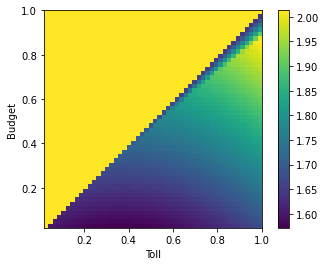

In [47]:
# lambda_E, lambda_R, lambda_I = 1.0, 1.0, 1.0

# plt.imshow(welfare_obj_arr.T, vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 
plt.imshow(welfare_obj_arr.T, extent=[np.min(tau_arr), np.max(tau_arr), np.min(B_arr), np.max(B_arr)], \
           vmin = min(welfare_obj_list), vmax = max(welfare_obj_list), origin='lower') 

plt.colorbar() 
plt.xlabel("Toll")
plt.ylabel("Budget")
# plt.xticks(x_positions, x_labels)

## Test:

In [ ]:
# Test:

grad = np.array([3.11430535, 1.501, 1.501, 2.46858321, 1.501])

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_el_var = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_in_var = cp.Variable(2)

objective = cp.Minimize(grad[0:3] @ y_el_var + grad[3:] @ y_in_var)

constraints = []
constraints += [y_el_var >= 0, y_in_var >= 0]
constraints += [cp.sum(y_el_var) == 1, cp.sum(y_in_var) == 1]
constraints += [y_el_var[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("grad:", grad)
print("y_el_var.value:", y_el_var.value)
# print("y_el_var_current:", y_el_var_current)
print("y_in_var.value:", y_in_var.value)
# print("y_in_var_current:", y_in_var_current)
print()

# y_el_var_current = y_el_var_current + 2/(k+2) * (y_el_var.value - y_el_var_current)
# y_in_var_current = y_in_var_current + 2/(k+2) * (y_in_var.value - y_in_var_current)

# y_iters[0:3, k] = y_el_var_current
# y_iters[3:, k] = y_in_var_current

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()

# Solver=SCS,verbose=False

In [ ]:
# y_el_var
# y_in_var
# np.hstack((y_el_var, y_in_var))

# Scratch Work:

In [ ]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()


# Old Code Below:

# Budget vs Discount - Theory

## 1 Eligible group, 1 Ineligible group (Theory)

In [ ]:
def F_11(val, ell, tau, alpha):
    return ell(val) + (1 - alpha) * tau - ell(2 - val)

def y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau = ell(2 - y^\star)
    
    assert tau < ell(ub_init) - ell(lb_init), "We must have tau < ell(2.0) - ell(0.0), else is trivial."
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0"
    assert ell(lb_init) + (1.0 - alpha) * tau < ell(ub_init)
    
    lb = lb_init
    ub = ub_init
    mid_val = (lb + ub)/2
    
    for k in range(num_iters):
#         print("F:", F_11(mid_val, ell, tau, alpha))
#         print("lb:", lb)
#         print("ub:", ub)
#         print("mid_val:", mid_val)
#         print()
        
        if F_11(mid_val, ell, tau, alpha) < 0:
            lb = mid_val
        else:
            ub = mid_val
        mid_val = (lb + ub)/2
    
    return (lb + ub)/2

# def fixed_point_eqn():
    


In [ ]:
t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
# tau = 0.4
# v_E = 1
# v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
tau = 0.7
v_E = 1
v_I = 2.5

num_alpha_grid_points = 100 # Should be even
alpha_vals = np.linspace(0, 1.0, num = num_alpha_grid_points + 1)

y_star_zero = y_star_11(ell, tau, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# print("y_star_zero:", y_star_zero)

y_star_vals = np.array([y_star_11(ell, tau, alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
y_star_vals_budget = alpha_vals
index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# print("index_min:", index_min)
# print("alpha_vals[index_min]:", alpha_vals[index_min])
# print("y_star_vals_budget:", y_star_vals_budget)
# print()

# print("y_star_vals:", y_star_vals)
# print()

y_star_vals_discount = np.copy(y_star_vals)
for k in range(y_star_vals_discount.shape[0]):
    if k <= index_max:
        y_star_vals_discount[k] = 0.0

tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# print("y_star_vals_budget:", y_star_vals_budget)

# print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

In [ ]:
print("1 - v^E / v^I:", 1 - v_E/v_I)
print("alpha_3:", alpha_3)

In [ ]:
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

# Scratch Work:

In [ ]:
# Test:

# y_el: \hat y_1 E, \tilde y_1 E, y_2 E
y_elig = cp.Variable(3)
# y_in: y_1 I, y_2 I
y_inel = cp.Variable(2)

a = np.array([0.0, 0.0, 0.0, 0.0, 1.0])

tau = 0.5
B = 0.4

func = 1/5 * a[4] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 5)
func += 1/4 * a[3] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 4)
func += 1/3 * a[2] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 3)
func += 1/2 * a[1] * cp.power(y_elig[0] + y_elig[1] + y_inel[0], 2)
func += a[0] * (y_elig[0] + y_elig[1] + y_inel[0])
func += y_inel[0] * tau / v_I + y_elig[0] * tau / v_E
func += 1/5 * a[4] * cp.power(y_elig[2] + y_inel[1], 5)
func += 1/4 * a[3] * cp.power(y_elig[2] + y_inel[1], 4)
func += 1/3 * a[2] * cp.power(y_elig[2] + y_inel[1], 3)
func += 1/2 * a[1] * cp.power(y_elig[2] + y_inel[1], 2)
func += a[0] * (y_elig[2] + y_inel[1])

objective = cp.Minimize(func)


constraints = []
constraints += [y_elig >= 0, y_inel >= 0]
constraints += [cp.sum(y_elig) == 1, cp.sum(y_inel) == 1]
constraints += [y_elig[1] * tau <= B]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print("y_elig.value:", np.round(y_elig.value, 4) )
print("y_inel.value:", np.round(y_inel.value, 4) )
print()



# power(x, p)

